# Deep Learning Term Project for ECG (DIL700)

## Loading dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings

from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

Collect all the data from the csv files

In [2]:
import os
import pandas as pd

def combine_csv_files_to_df(dir_path):
    # Get all CSV files in the directory
    csv_files = [file for file in os.listdir(dir_path) if file.endswith('.csv')]

    df_list = [pd.read_csv(os.path.join(dir_path, file), header=None) for file in csv_files]
    combined_data = pd.concat(df_list, ignore_index=True,)

    # Display the combined DataFrame
    return(combined_data)


In [3]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')

In [4]:
train_df.head()

0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 188 columns]

In [5]:
test_df.head()

0         1         2         3         4         5         6    \
0  1.000000  0.758264  0.111570  0.000000  0.080579  0.078512  0.066116   
1  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
2  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
3  1.000000  0.910417  0.681250  0.472917  0.229167  0.068750  0.000000   
4  0.570470  0.399329  0.238255  0.147651  0.000000  0.003356  0.040268   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.049587  0.047521  0.035124  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.123894  0.115044  0.132743  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.004167  0.014583  0.054167  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.080537  0.070470  0.090604  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 188 columns]

In [6]:
print(train_df[187].unique())

[0. 1. 2. 3. 4.]


In [7]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion of ventricular and normal', 'Paced']

In [8]:
print('Number of samples in train data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Atrial premature:                    ', len(train_df[train_df[187]==1]))
print('Premature ventricular contraction:   ', len(train_df[train_df[187]==2]))
print('Fusion of ventricular and normal:    ', len(train_df[train_df[187]==3]))
print('Paced:                               ', len(train_df[train_df[187]==4]))

Number of samples in train data:
Normal:                               72471
Atrial premature:                     2223
Premature ventricular contraction:    5788
Fusion of ventricular and normal:     641
Paced:                                6431


In [9]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Atrial premature:                    ', len(test_df[test_df[187]==1]))
print('Premature ventricular contraction:   ', len(test_df[test_df[187]==2]))
print('Fusion of ventricular and normal:    ', len(test_df[test_df[187]==3]))
print('Paced:                               ', len(test_df[test_df[187]==4]))

Number of samples in test data:
Normal:                               18118
Atrial premature:                     556
Premature ventricular contraction:    1448
Fusion of ventricular and normal:     162
Paced:                                1608


## Create feautures and labels for dataset

Create different dataframes for training/testing data and labels.
Also OneHotEncoding for the labels and renaming the classes

In [10]:
train_X = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]
train_y = pd.get_dummies(train_y, columns=[1])
train_y = train_y.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

test_X = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]
test_y = pd.get_dummies(test_y, columns=[1])
test_y = test_y.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

In [11]:
train_X.head()

0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  177  178  179  180  181  182  183  184  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   185  186  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 187 columns]

In [12]:
train_y.head()

N  S  V  F  Q
0  1  0  0  0  0
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
4  1  0  0  0  0

In [13]:
test_X.head()

0         1         2         3         4         5         6    \
0  1.000000  0.758264  0.111570  0.000000  0.080579  0.078512  0.066116   
1  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
2  0.730088  0.212389  0.000000  0.119469  0.101770  0.101770  0.110619   
3  1.000000  0.910417  0.681250  0.472917  0.229167  0.068750  0.000000   
4  0.570470  0.399329  0.238255  0.147651  0.000000  0.003356  0.040268   

        7         8         9    ...  177  178  179  180  181  182  183  184  \
0  0.049587  0.047521  0.035124  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.123894  0.115044  0.132743  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.004167  0.014583  0.054167  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.080537  0.070470  0.090604  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   185  186  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 187 columns]

In [14]:
test_y.head()

N  S  V  F  Q
0  1  0  0  0  0
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
4  1  0  0  0  0

## Visualization

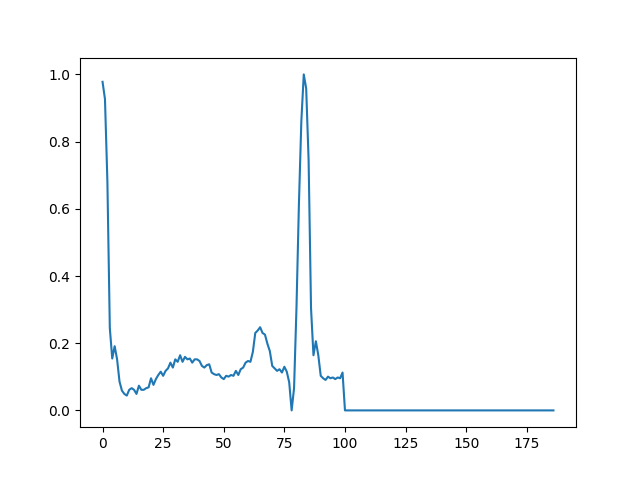

In [15]:
ecg_example = train_df.iloc[0,:187]
plt.plot(ecg_example)

In [16]:
i = 80000
ecg_example = train_df.iloc[i,:187]
print(train_df.iloc[i,187])
plt.plot(ecg_example)

2.0


In [17]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


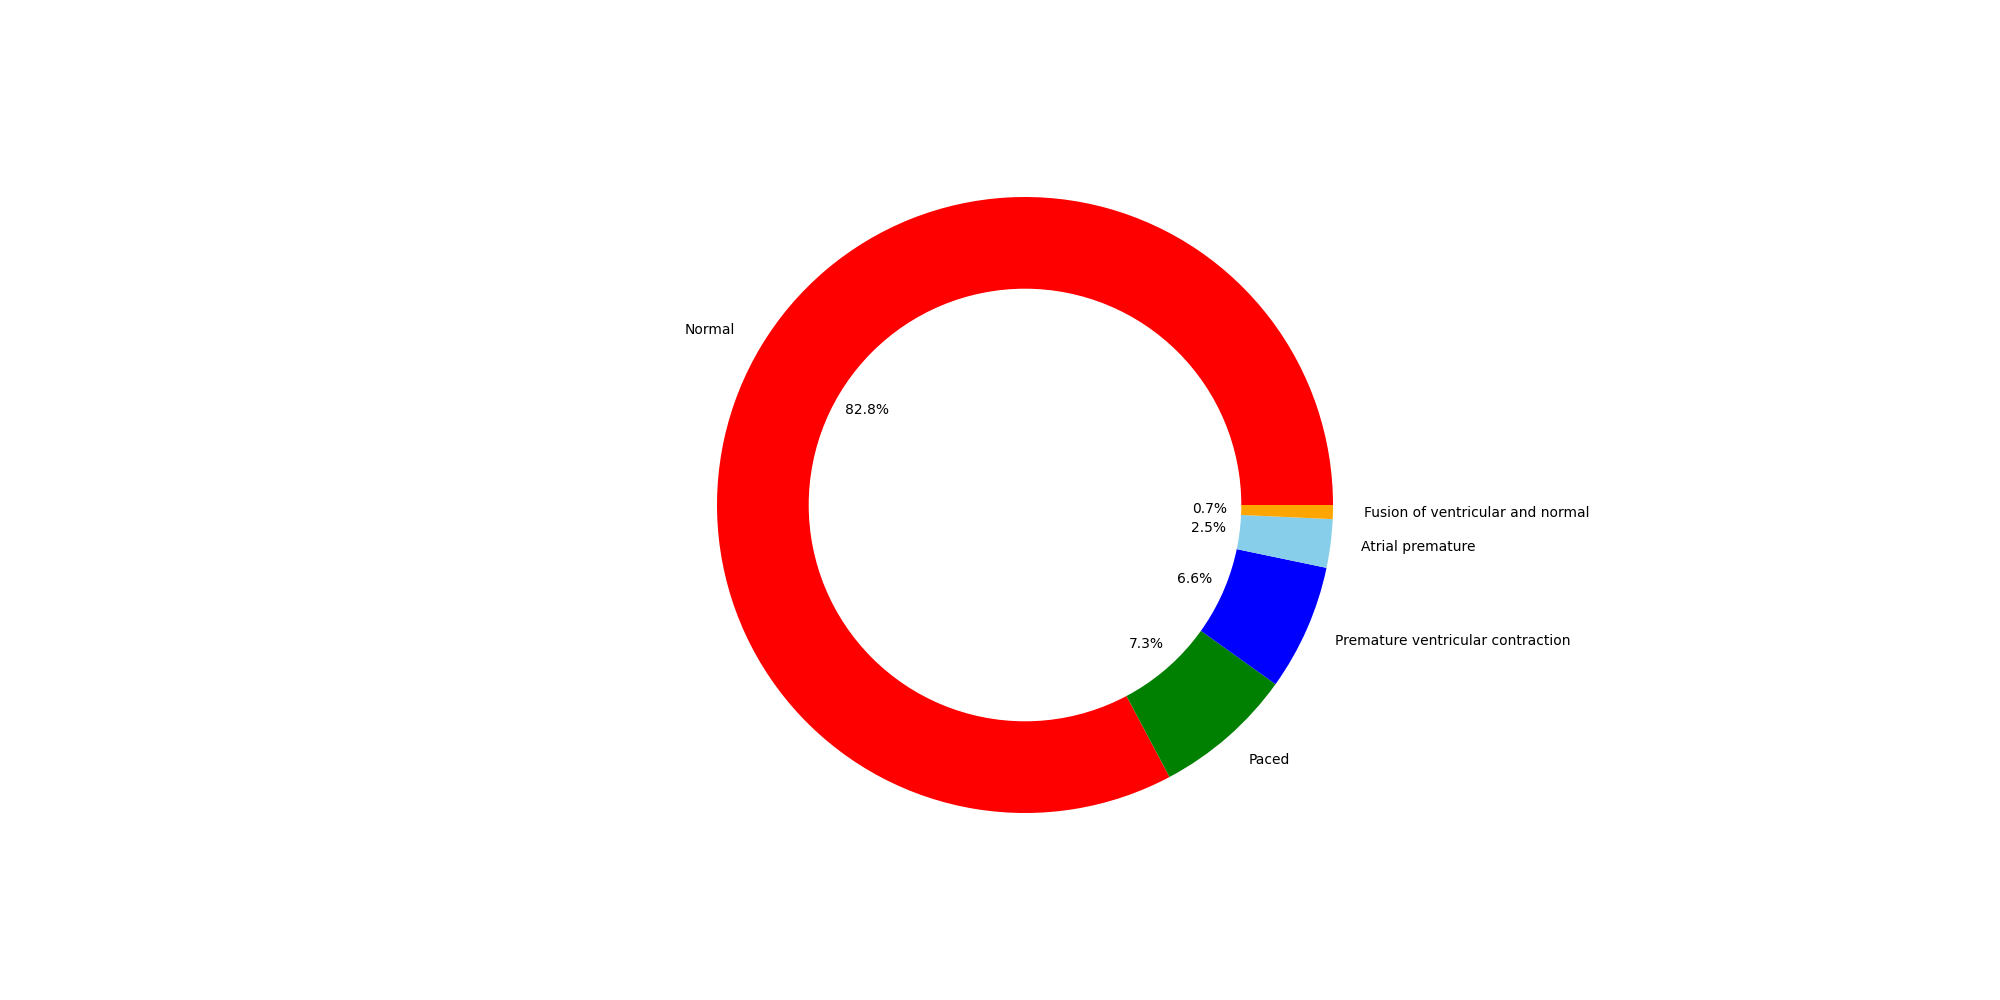

In [18]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels= ['Normal', 'Paced', 'Premature ventricular contraction','Atrial premature', 'Fusion of ventricular and normal']
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [19]:
def plot_ecg_examples(df, label, n_examples=5):    
    filtered_df = df[df[187] == label]

    # choose 5 random instances from the filtered DataFrame
    random_instances = filtered_df.sample(n=n_examples, random_state=42)

    return random_instances


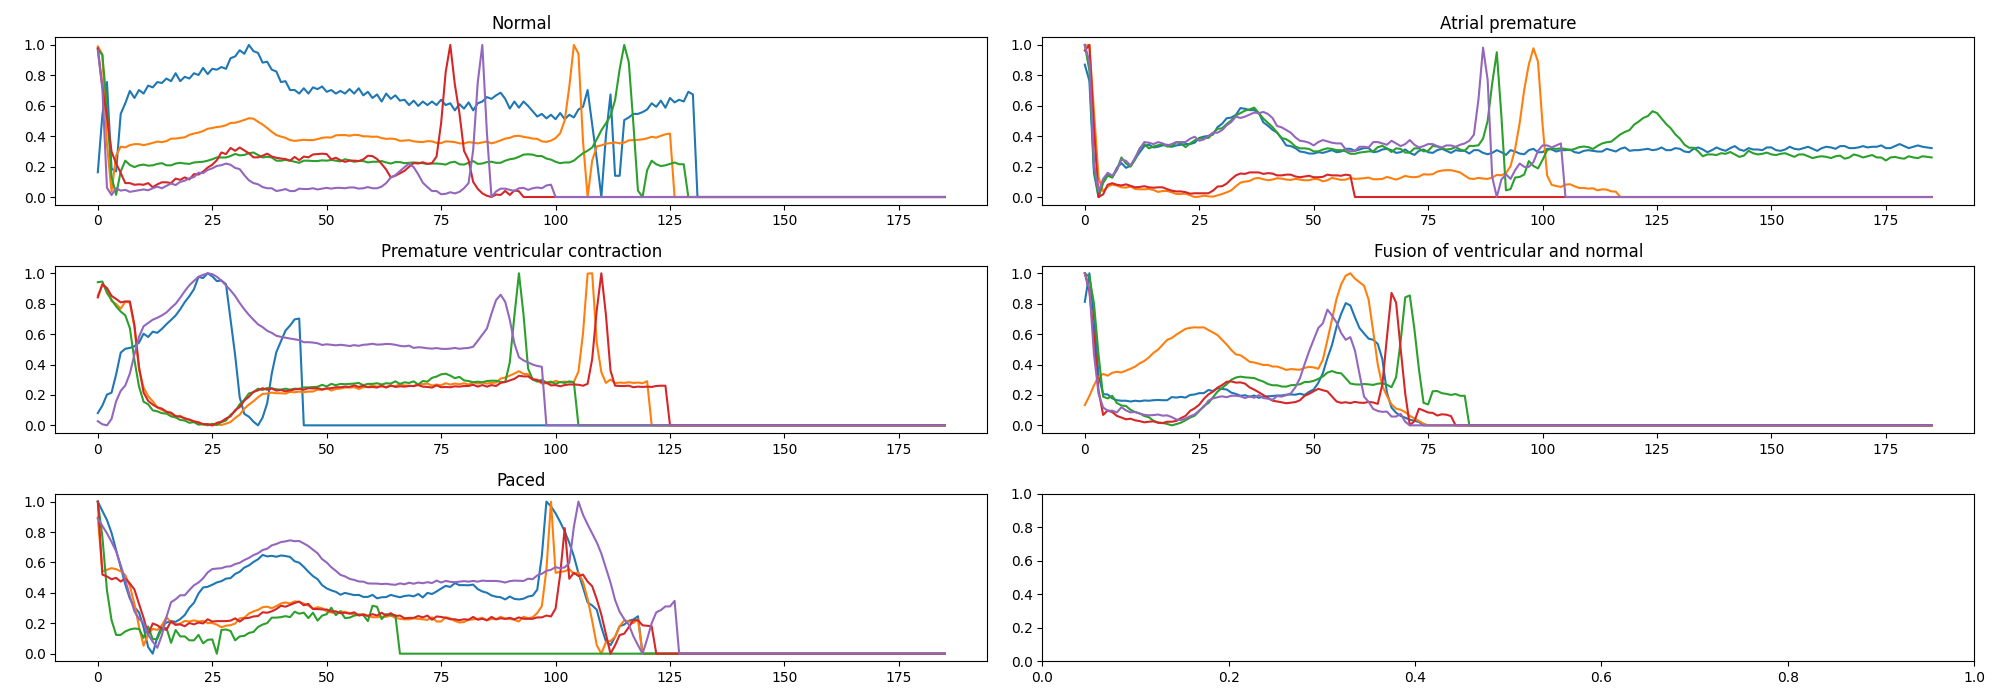

In [20]:
samples = list()
samples.append(plot_ecg_examples(train_df, 0, 5))
samples.append(plot_ecg_examples(train_df, 1, 5))
samples.append(plot_ecg_examples(train_df, 2, 5))
samples.append(plot_ecg_examples(train_df, 3, 5))
samples.append(plot_ecg_examples(train_df, 4, 5))


fig, axs = plt.subplots(3, 2, figsize=(20, 7))
titles = ['Normal', 'Atrial premature', 'Premature ventricular contraction', 'Fusion of ventricular and normal', 'Paced']
for i in range(5):
    ax = axs.flat[i]
    ax.plot(samples[i].values[:,:-2].transpose())
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()

# Heatmaps classes

In [21]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

## Heatmap of class 0 (Normal)

4710615
4710615


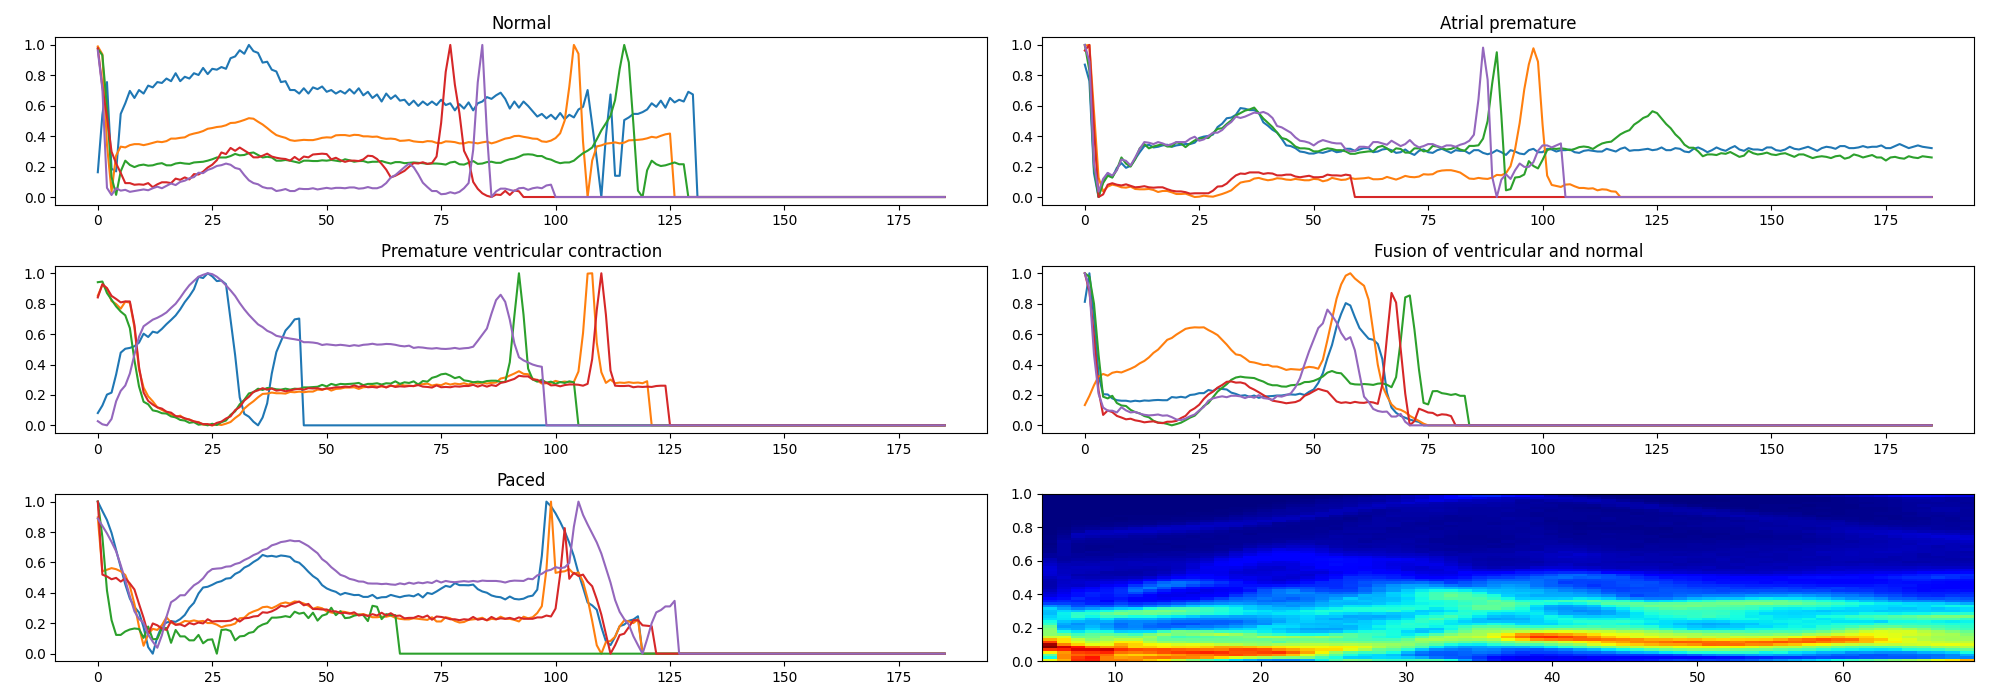

In [22]:
hist_class0 = plot_hist(0,70,5,65)

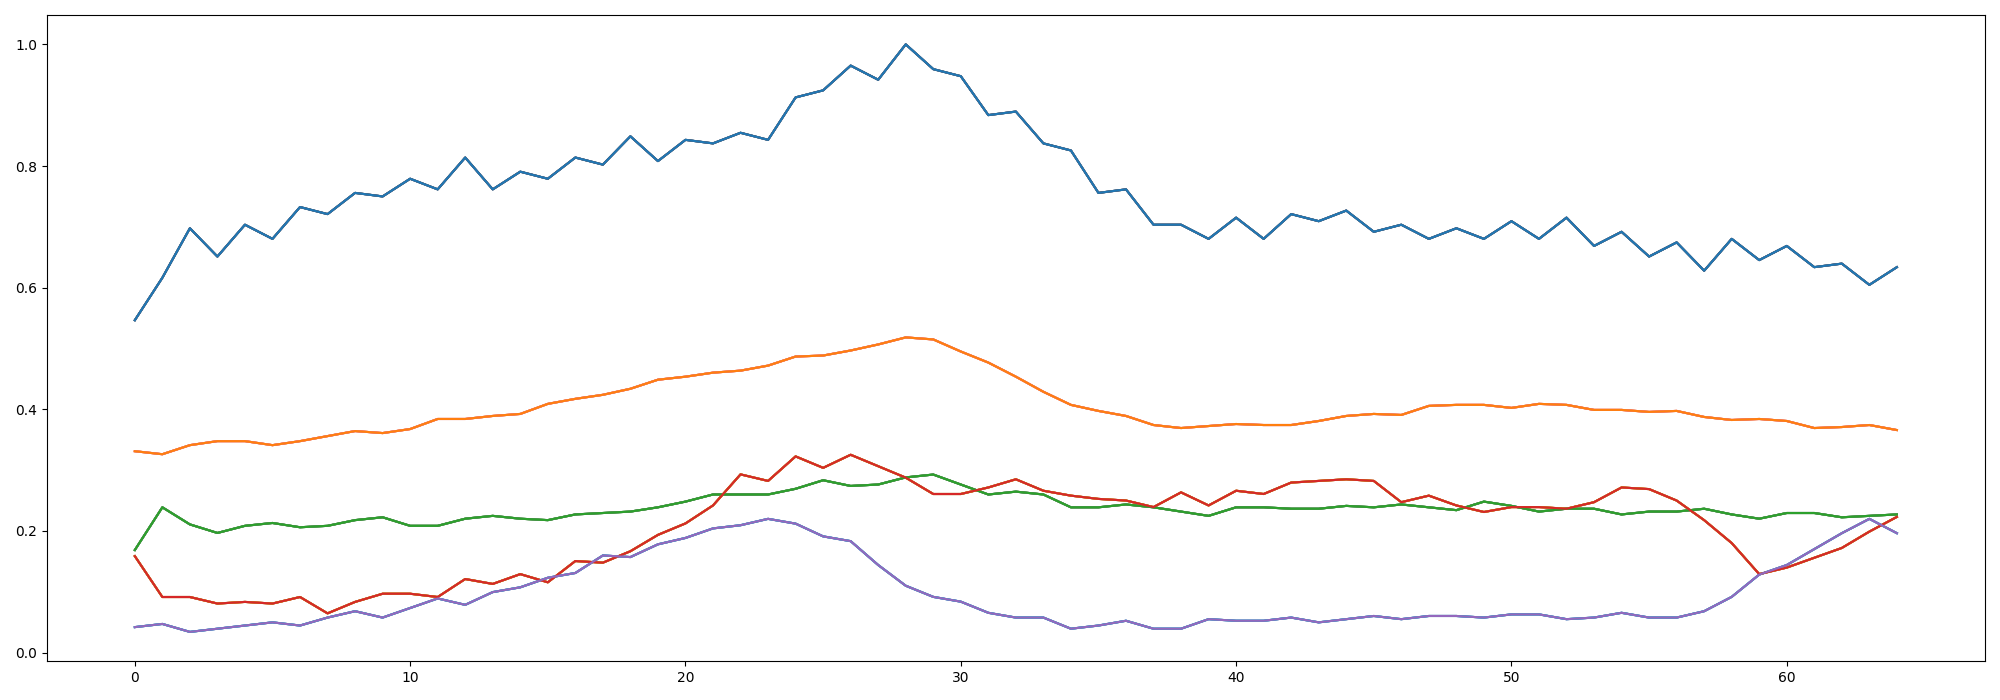

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
class0 = plot_ecg_examples(train_df, 0, n_examples=5)
for i in range(5):
    #ax = axs.flat[i]
    axs.plot(class0.values[:,:-2].transpose()[5:70])
    #ax.set_title(titles[i])
fig.tight_layout()
plt.show()

## Heatmap of class 1 (Atrial premature)

100035
100035


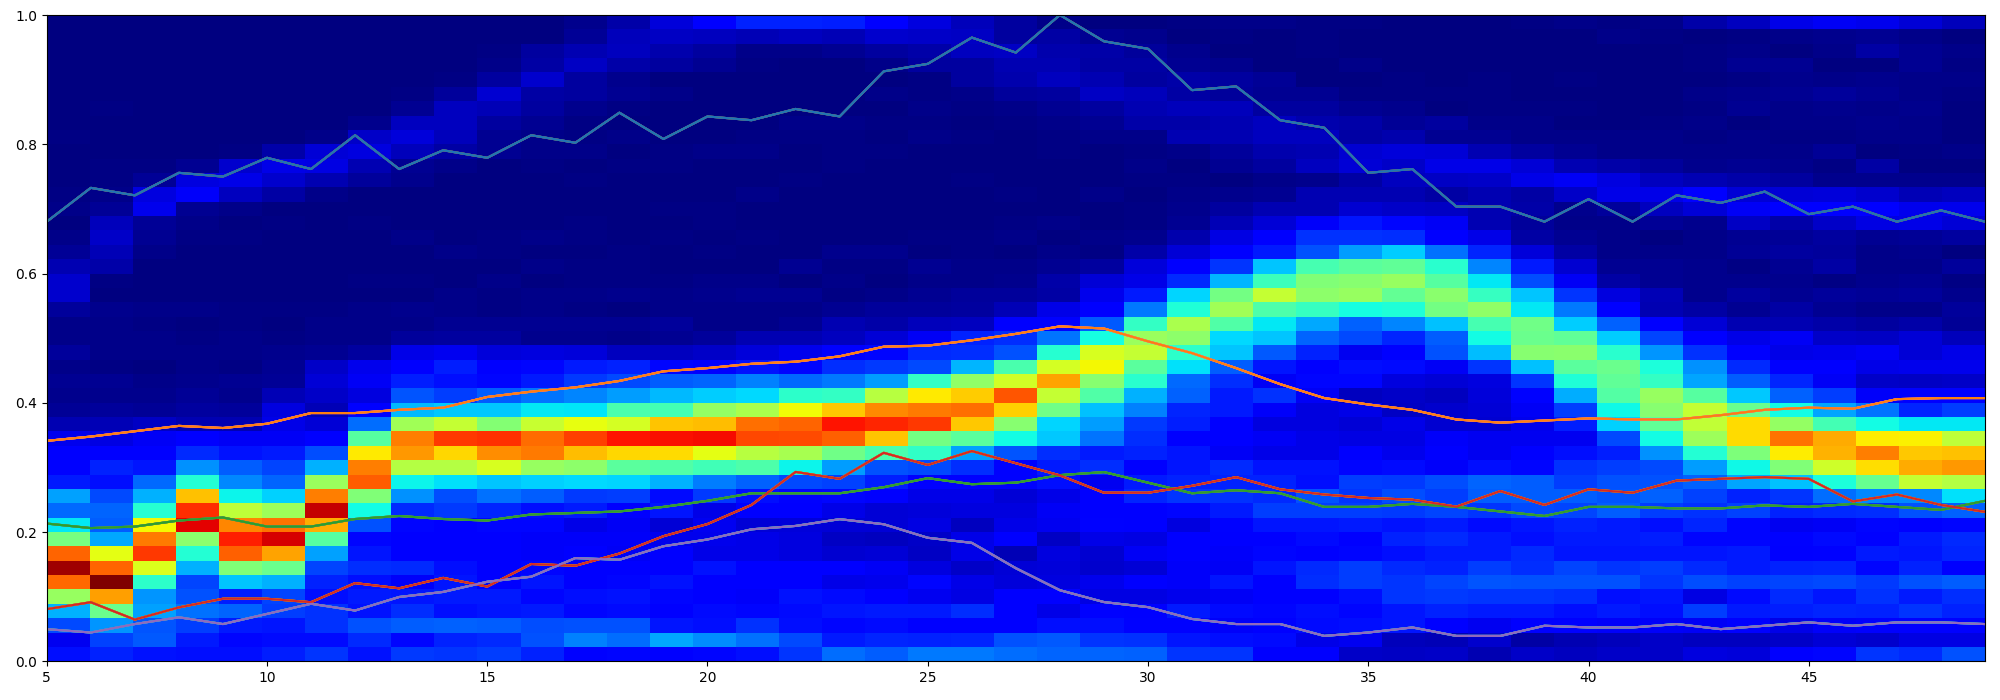

In [24]:
hist_class1 = plot_hist(1,50,5,45)

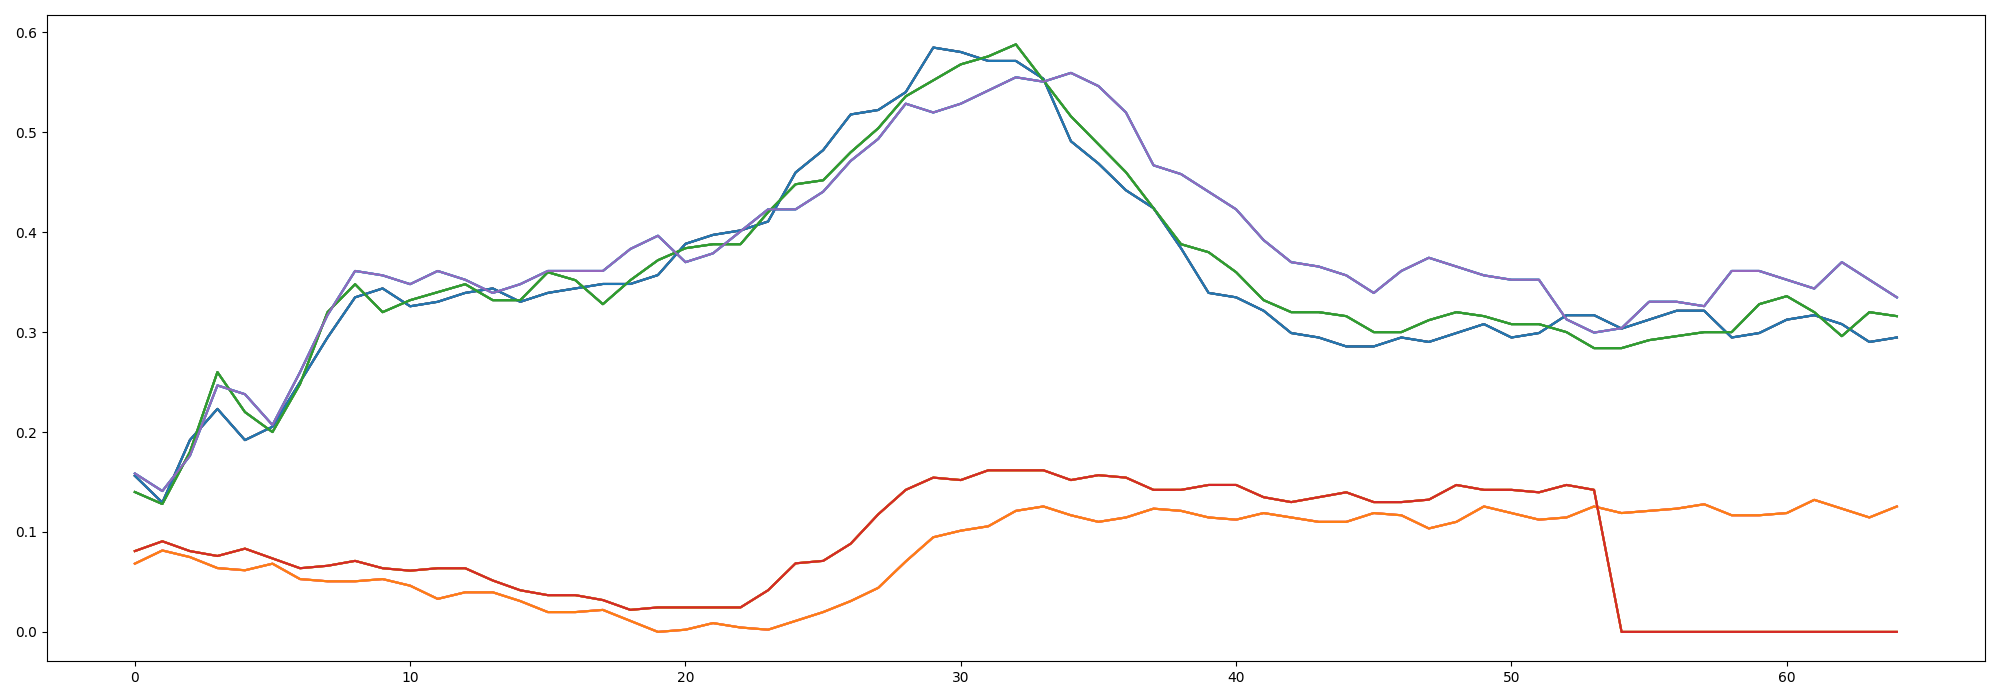

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
class1 = plot_ecg_examples(train_df, 1, n_examples=5)
for i in range(5):
    #ax = axs.flat[i]
    axs.plot(class1.values[:,:-2].transpose()[5:70])
    #ax.set_title(titles[i])
fig.tight_layout()
plt.show()

## Heatmap of class 2 (Premature ventricular contraction)

260460
260460


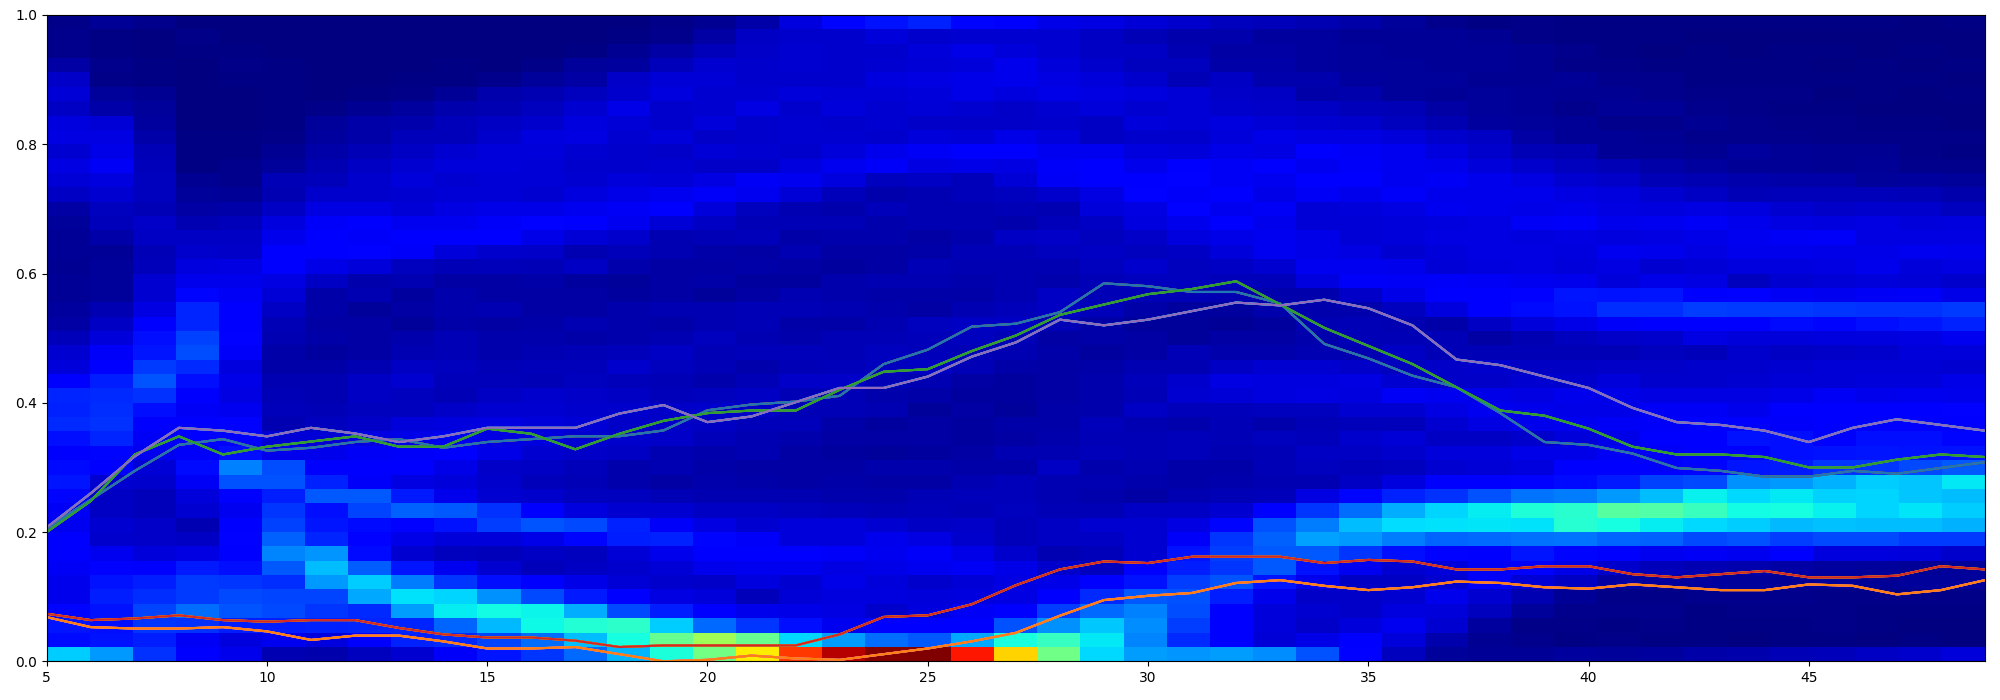

In [26]:
hist_class2 = plot_hist(2,50,5,45)

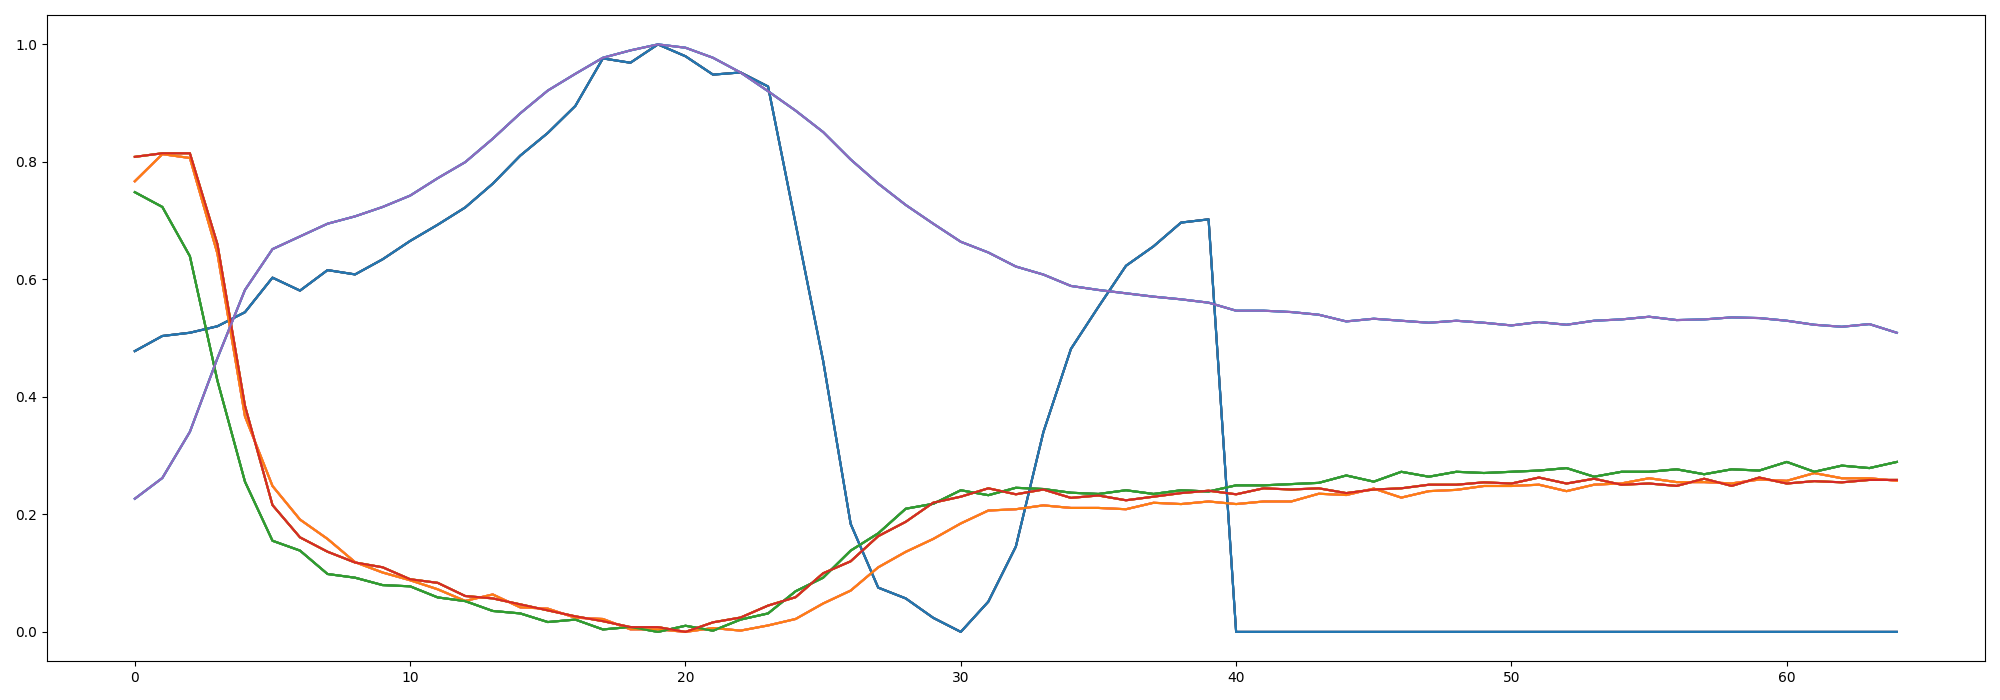

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
class2 = plot_ecg_examples(train_df, 2, n_examples=5)
for i in range(5):
    #ax = axs.flat[i]
    axs.plot(class2.values[:,:-2].transpose()[5:70])
    #ax.set_title(titles[i])
fig.tight_layout()
plt.show()

## Heatmap of class 3 (Fusion of ventricular and normal)

35255
35255


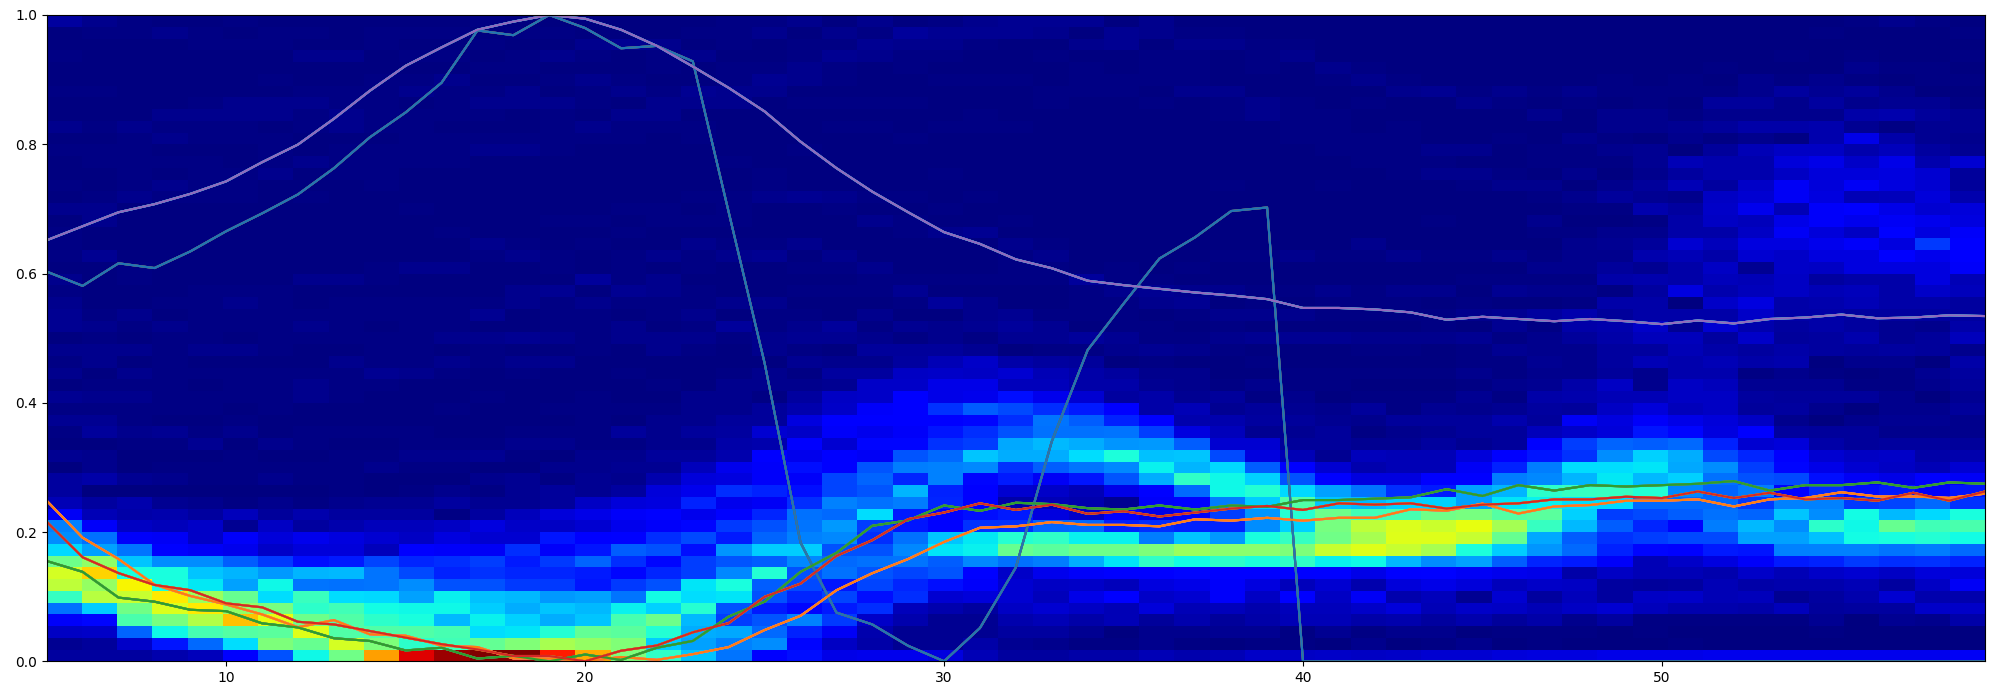

In [28]:
hist_class3 = plot_hist(3,60,5,55)

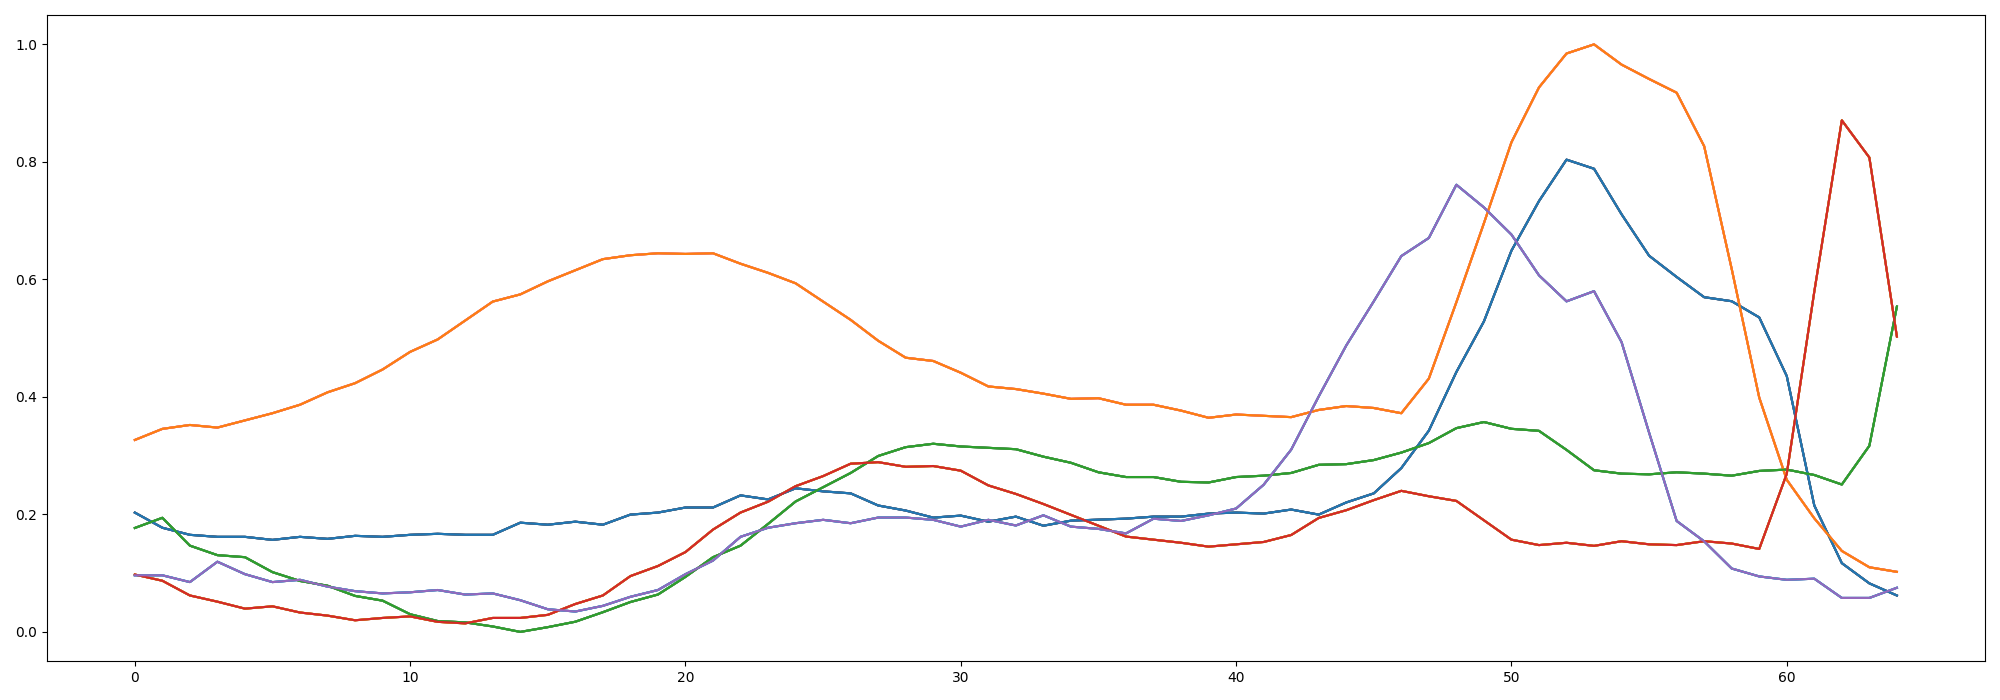

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
class3 = plot_ecg_examples(train_df, 3, n_examples=5)
for i in range(5):
    #ax = axs.flat[i]
    axs.plot(class3.values[:,:-2].transpose()[5:70])
    #ax.set_title(titles[i])
fig.tight_layout()
plt.show()

## Heatmap of class 4 (Paced)

418015
418015


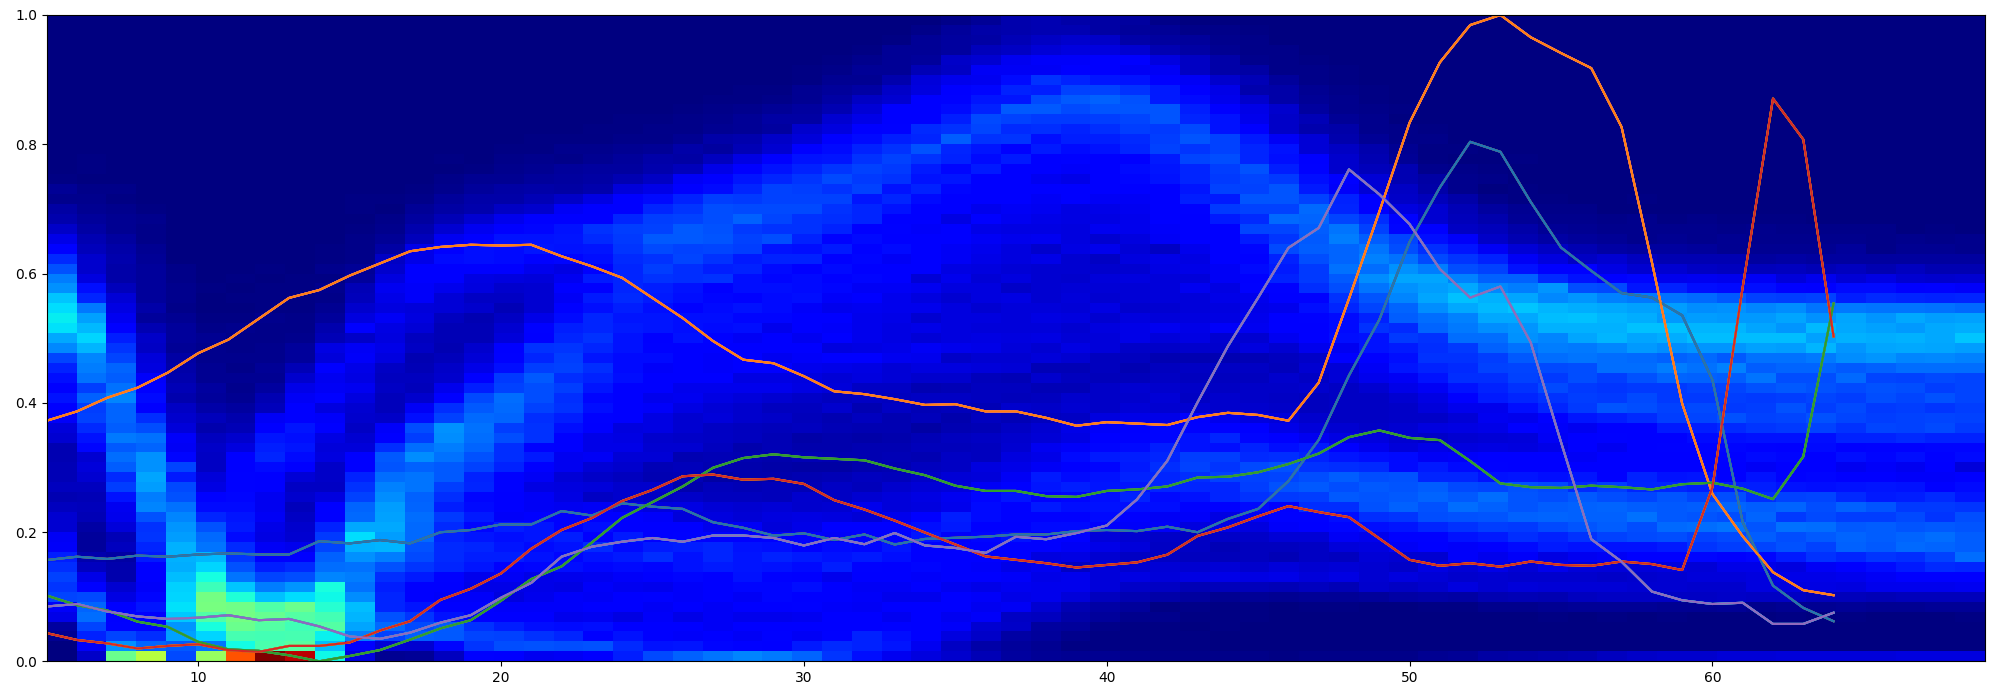

In [30]:
hist_class4 = plot_hist(4,70,5,65)

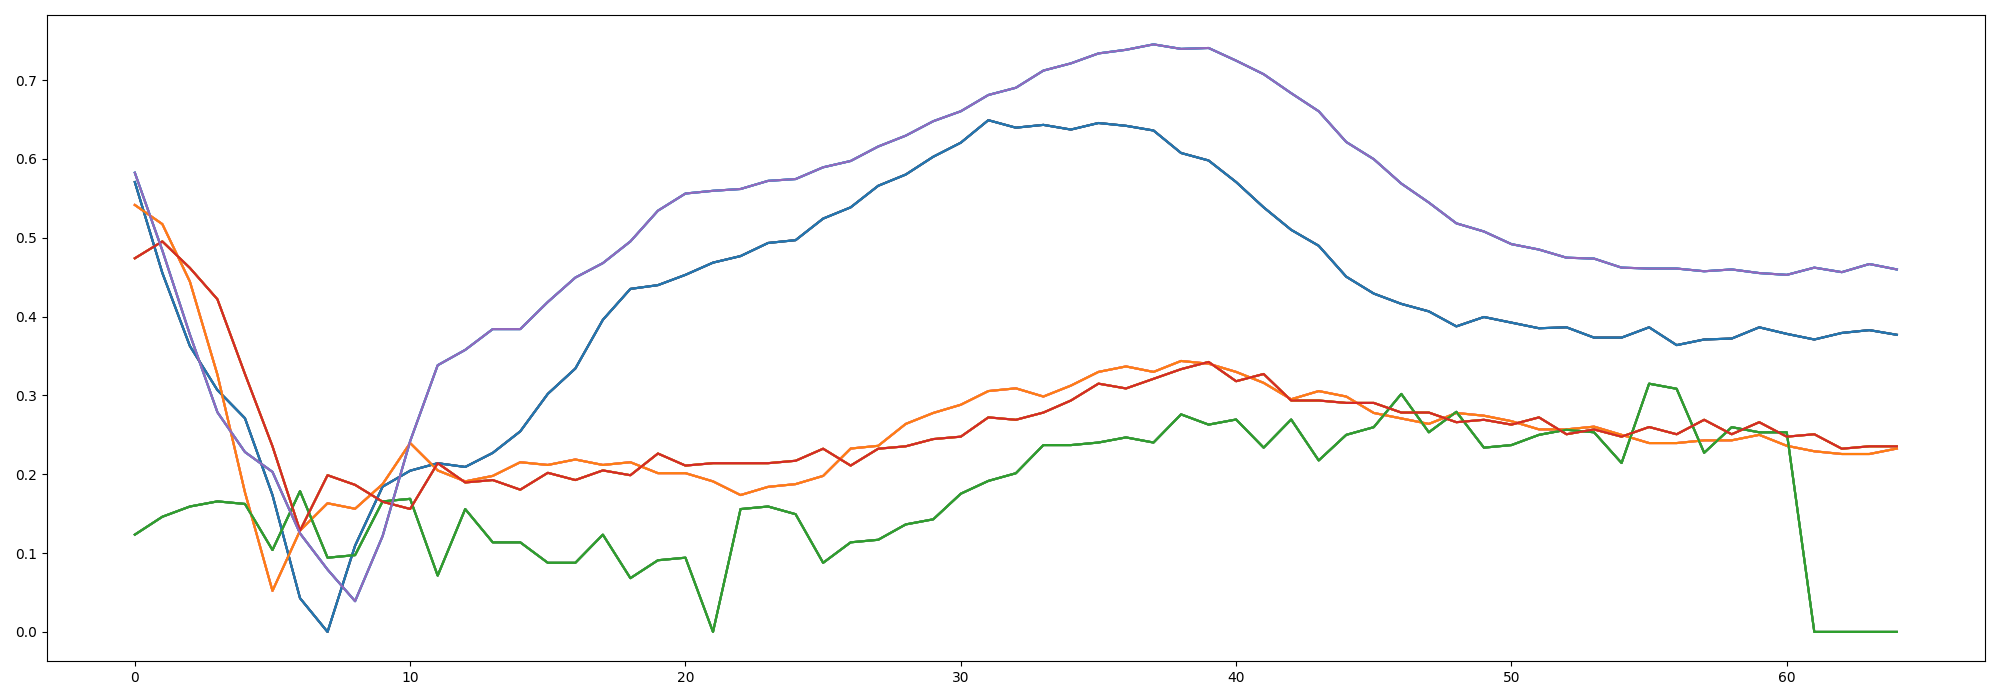

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
class4 = plot_ecg_examples(train_df, 4, n_examples=5)
for i in range(5):
    #ax = axs.flat[i]
    axs.plot(class4.values[:,:-2].transpose()[5:70])
    #ax.set_title(titles[i])
fig.tight_layout()
plt.show()

## TSNE

In [32]:
def get_random_data_from_class(df, class_number, n_examples=5):
    filtered_df = df[df[187] == class_number]
    random_instances = filtered_df.sample(n=n_examples, random_state=42)
    return random_instances

Testing part for a TSNE with 3 components and 100 instances from each class

In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, random_state=123)

tsne_data_0 = get_random_data_from_class(train_df, 0, n_examples=100)
tsne_data_1 = get_random_data_from_class(train_df, 1, n_examples=100)
tsne_data_2 = get_random_data_from_class(train_df, 2, n_examples=100)
tsne_data_3 = get_random_data_from_class(train_df, 3, n_examples=100)
tsne_data_4 = get_random_data_from_class(train_df, 4, n_examples=100)
# put the different dataframes into one dataframe
tsne_data = pd.concat([tsne_data_0, tsne_data_1, tsne_data_2, tsne_data_3, tsne_data_4], axis=0)
z0 = tsne.fit_transform(tsne_data.values[:,:-1])


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.959943
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.593346
[t-SNE] KL divergence after 1000 iterations: 0.335699


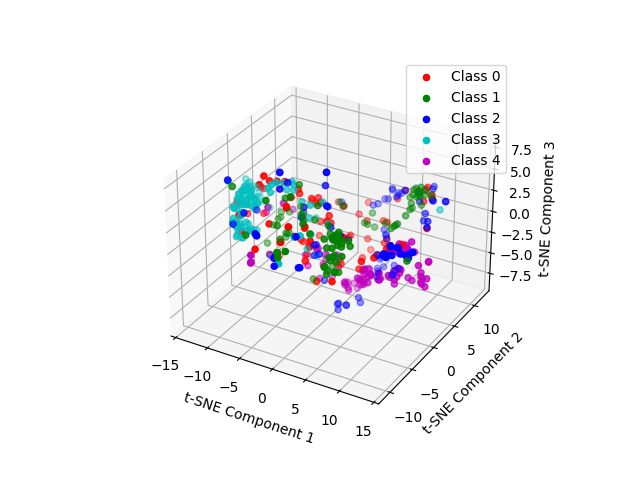

In [34]:
# Create a 3D scatter plot
n_classes = 5
y = tsne_data[187]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'c', 'm']

for i in range(n_classes):
    idx = np.where(y == i)
    #print(idx)
    ax.scatter(z0[idx,0], z0[idx,1], z0[idx,2], c=colors[i], label=f"Class {i}")

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.show()


## Training some ML Models

### SVM

In [35]:
from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# # Split data into training and testing sets
# X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(z0, tsne_data[187], test_size=0.2, random_state=42)

# Train SVM classifier
svm = SVC(kernel='poly', C=1, decision_function_shape='ovr')
svm.fit(train_X, train_df[187])

# Evaluate SVM classifier
accuracy = svm.score(test_X, test_df[187])
print(f'SVM classifier accuracy: {accuracy:.2f}')

SVM classifier accuracy: 0.97


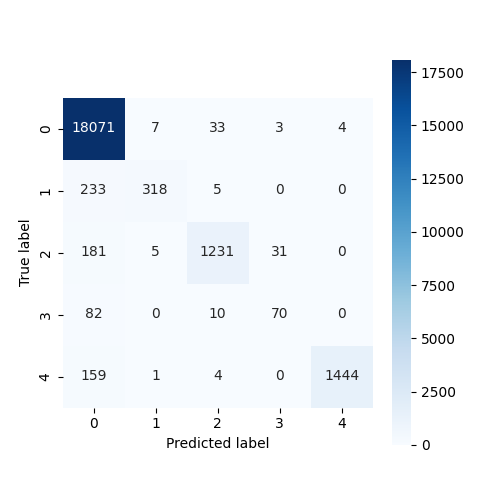

In [36]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Predict test set labels
y_pred_svm = svm.predict(test_X)

# Calculate confusion matrix
cm = confusion_matrix(test_df[187], y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [37]:
print(classification_report(test_df[187], y_pred_svm, target_names=labels))

                                   precision    recall  f1-score   support

                           Normal       0.97      1.00      0.98     18118
                 Artial Premature       0.96      0.57      0.72       556
Premature ventricular contraction       0.96      0.85      0.90      1448
 Fusion of ventricular and normal       0.67      0.43      0.53       162
                            Paced       1.00      0.90      0.95      1608

                         accuracy                           0.97     21892
                        macro avg       0.91      0.75      0.81     21892
                     weighted avg       0.96      0.97      0.96     21892



In [38]:
from sklearn.ensemble import RandomForestClassifier

# Train random forest classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rfc.fit(train_X, train_df[187])

# Evaluate random forest classifier
accuracy = rfc.score(test_X, test_df[187])
print(f'Random forest classifier accuracy: {accuracy:.2f}')

Random forest classifier accuracy: 0.97


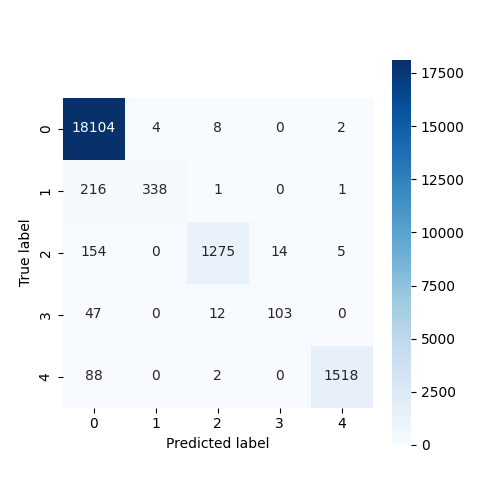

In [39]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Predict test set labels
y_pred_rfc = rfc.predict(test_X)

# Calculate confusion matrix
cm = confusion_matrix(test_df[187], y_pred_rfc)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [40]:
print(classification_report(test_df[187], y_pred_rfc, target_names=labels))

                                   precision    recall  f1-score   support

                           Normal       0.97      1.00      0.99     18118
                 Artial Premature       0.99      0.61      0.75       556
Premature ventricular contraction       0.98      0.88      0.93      1448
 Fusion of ventricular and normal       0.88      0.64      0.74       162
                            Paced       0.99      0.94      0.97      1608

                         accuracy                           0.97     21892
                        macro avg       0.96      0.81      0.87     21892
                     weighted avg       0.97      0.97      0.97     21892



## CNN

In [49]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

im_shape=(train_X.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


model = Model(inputs= inputs_cnn, outputs=main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=8),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(train_X, train_y,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(test_X,test_y))
model.load_weights('best_model.h5')



Epoch 1/40
2737/2737 [==============================] - 19s 7ms/step - loss: 0.1236 - accuracy: 0.9643 - val_loss: 0.0898 - val_accuracy: 0.9757
Epoch 2/40
2737/2737 [==============================] - 20s 7ms/step - loss: 0.0707 - accuracy: 0.9789 - val_loss: 0.0900 - val_accuracy: 0.9759
Epoch 3/40
2737/2737 [==============================] - 18s 7ms/step - loss: 0.0560 - accuracy: 0.9835 - val_loss: 0.0802 - val_accuracy: 0.9810
Epoch 4/40
2737/2737 [==============================] - 18s 7ms/step - loss: 0.0458 - accuracy: 0.9861 - val_loss: 0.0812 - val_accuracy: 0.9804
Epoch 5/40
2737/2737 [==============================] - 19s 7ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0837 - val_accuracy: 0.9798
Epoch 6/40
2737/2737 [==============================] - 19s 7ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.0885 - val_accuracy: 0.9737
Epoch 7/40
2737/2737 [==============================] - 18s 7ms/step - loss: 0.0294 - accuracy: 0.9905 - val_loss: 0.0735 - val_ac

In [50]:
scores = model.evaluate(test_X, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 98.36%


In [51]:
# Predict test set labels
y_pred = model.predict(test_X)
y_pred_cnn = np.argmax(y_pred, axis=1)

685/685 [==============================] - 1s 2ms/step


In [52]:
print(classification_report(test_df[187], y_pred_cnn, target_names=labels))

                                   precision    recall  f1-score   support

                           Normal       0.99      1.00      0.99     18118
                 Artial Premature       0.92      0.74      0.82       556
Premature ventricular contraction       0.97      0.93      0.95      1448
 Fusion of ventricular and normal       0.75      0.77      0.76       162
                            Paced       0.99      0.99      0.99      1608

                         accuracy                           0.98     21892
                        macro avg       0.93      0.89      0.90     21892
                     weighted avg       0.98      0.98      0.98     21892

